# Example 3- Coupled nonlinear oscillators on Fashion MNIST

In this example, we consider a physical neural network based on coupled nonlinear oscillators. Here we consider an all-to-all connected coupled nonlinear oscillators that obeys the following equation of motion. 

$$ \frac{\mathrm{d}^2q_i}{\mathrm{d} t^2} = -\sin{q_i} + \sum_{j=1}^N J_{ij}\left( \sin{q_j} - \sin{q_i} \right) +e_i $$ 
where $q_i$ are the oscillator amplitudes, $J_{ij}$ are the coupling coefficients (which must be symmetric, i.e., $J_{ij}=J_{ji}$), and $e_i$ are individual oscillator drives. 

The oscillator system is turned into a PNN by the following input output map. We encode the data into the initial amplitudes, and the output is taken to be state of the oscillator after some time-evolution.  Because this is a second order ODE, the first derivatives are set to 0, so the system begins at rest $\dot q_i (t=0) = 0$.

In this notebook, we show such a PNN can be trained to perform the Fashion MNIST task. 

In order to simulate the effect of the mismatch between model and experiment that is addressed by physics-aware training, we add noise to (a) the nonlinearity coefficient, and (b) the coupling coefficients J_ij. Thus, while the model remains described by the equation above, the physical system is described by:
$$    \frac{\mathrm{d}^2q_i}{\mathrm{d} t^2} = -\sin({(1+\eta)q_i}) + \sum_{j=1}^N (J_{ij}+J^{\mathrm{noise}}_{ij})\left( \sin({(1+\eta)q_j}) - \sin({(1+\eta) q_i}) \right) +e_i $$

The architecture we consider for this PNN is as follows - see caption for detail.
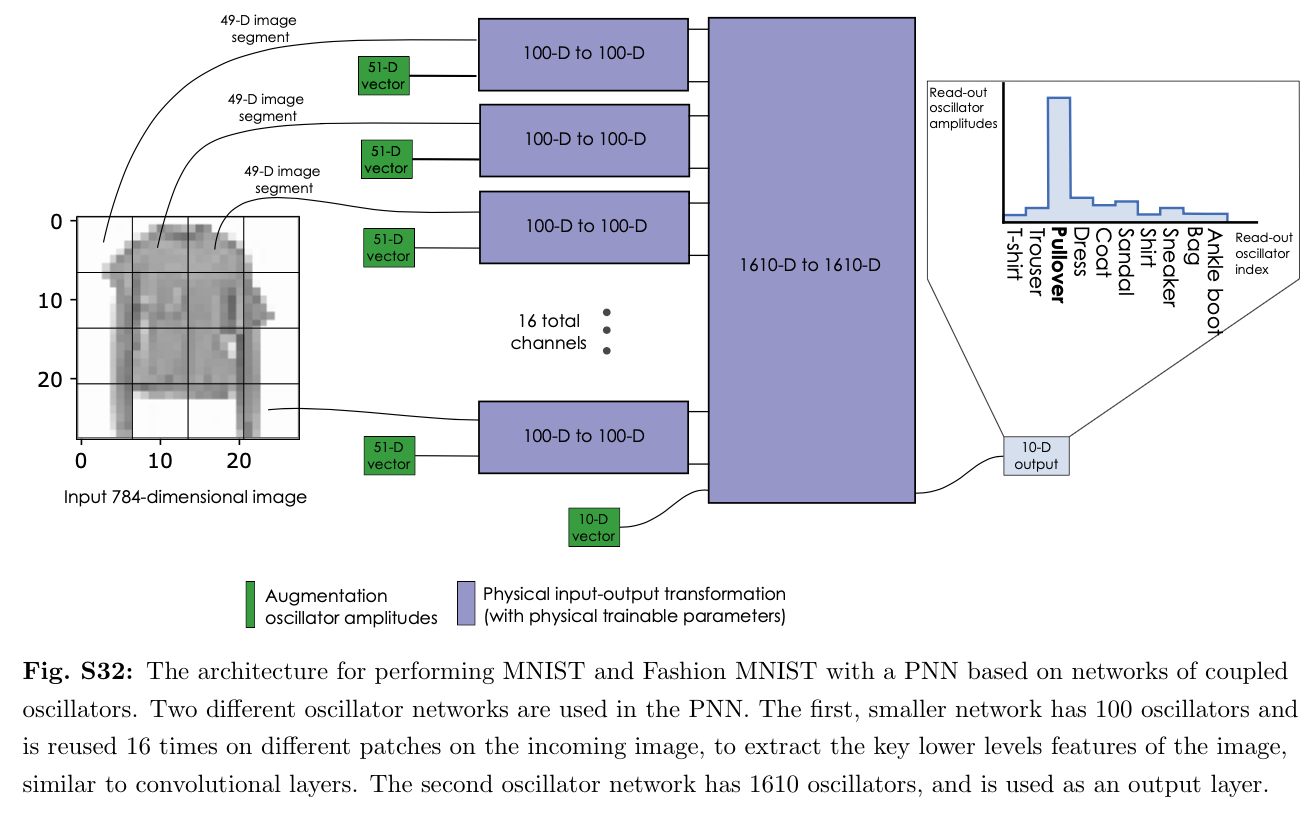

## Loading the Fashion MNIST dataset

In [1]:
batch_size = 32
from torchvision.datasets import FashionMNIST
import torch
from torchvision import transforms
from torch.utils.data.dataloader import DataLoader
compress_factor = 1
reshape_f = lambda x: torch.reshape(x[0, ::compress_factor, ::compress_factor], (-1, ))
transform = transforms.Compose([transforms.ToTensor()])

In [2]:
transform_noise = transforms.Compose([
    transforms.RandomHorizontalFlip(), 
    transforms.ToTensor()])

transform_val = transforms.Compose([transforms.ToTensor()])

train_set = (FashionMNIST(
    root = '../..',
    train = True,
    download = True,
    transform = transform_noise
))

val_set = (FashionMNIST(
    root = '../..',
    train = False,
    download = True,
    transform = transform_val
))

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)

/usr/local/anaconda/envs/NN_v2/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


### Plotting an example fashion MNIST image and its associated label

'T-shirt'

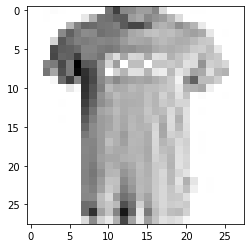

In [5]:
import matplotlib.pylab as plt

torch.manual_seed(0)
x, y = next(iter(train_loader))

labels = ["T-shirt", "Trouser", "Pullover", "Dress", "Coat", 
          "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

ind = 3

plt.imshow(x[ind].reshape(28, 28), cmap="binary")

labels[y[ind]]

### Parameters of the architecture and simulation

In [21]:
device = 0 #gpu number, use "cpu" if running on CPU

#parameters associated with the architecture
image_size = 28
patch_size = 7
dim = 100
num_patches = (image_size // patch_size) ** 2

#parameters associated with noise
noise = 0.2
η = 0.1
stochastic_noise = 0.02

#parameters associated with the ODE solver
Nt = 5
tend = 0.5
dt = tend/Nt

## Defining the differential equation and utility functions for solving them

In [22]:
#Generate code for solving ODEs with RK4
def rk_loop(f, x, h, *args):
    k1 = f(x, *args)
    k2 = f(x+h*k1/2, *args)
    k3 = f(x+h*k2/2, *args)
    k4 = f(x+h*k3, *args)
    return x + (h/6.0)*(k1 + 2*k2 + 2*k3 + k4)

def make_ode_map(f):
    def ode_map(x, *args):
        for i in range(Nt):
            x = rk_loop(f, x, dt, *args)
        return x  
    return ode_map

#set of ODEs that we consider in the numerical experiment
def ode(z, Jmat, Jbias):
    q = z[..., 0]
    p = z[..., 1]
    output = torch.empty_like(z)
    output[..., 0] = p
    sin_q = torch.sin(q)
    output[..., 1] = -sin_q + Jbias + sin_q@Jmat
    return  output

def ode_conv_exp(z, Jmat, Jbias):
    q = z[..., 0]
    p = z[..., 1]
    output = torch.empty_like(z)
    output[..., 0] = p
    sin_q = torch.sin((1+η)*q)
    output[..., 1] = -sin_q + Jbias + sin_q@Jmat + sin_q@J_conv_noise
    return  output

def ode_fc_exp(z, Jmat, Jbias):
    q = z[..., 0]
    p = z[..., 1]
    output = torch.empty_like(z)
    output[..., 0] = p
    sin_q = torch.sin((1+η)*q)
    output[..., 1] = -sin_q + Jbias + sin_q@Jmat + sin_q@J_fc_noise
    return  output

#function to generate the input noise of setting the initial oscillator amplitudes
def make_noise(x):
    n_tensor = torch.zeros_like(x)
    n_tensor[..., 0] = stochastic_noise*torch.randn(x.shape[:-1])
    return n_tensor

#defining an effective J matrix to speed up the computation
def symmetrize_J(J):
    J = (J + J.T)/2
    Jcolsum = -torch.sum(J, axis=0)
    inds = list(range(J.shape[0]))
    J[inds, inds] = Jcolsum
    return J

#passing this symmetrization operation to the ODE solver
def make_f_sym(f):
    def f_symJ(x, Jmat, *args):
        J_sym = symmetrize_J(Jmat)
        return f(x, J_sym, *args)
    return f_symJ

f_model = make_f_sym(make_ode_map(ode))
f_conv_pre = make_f_sym(make_ode_map(ode_conv_exp))
f_fc_pre = make_f_sym(make_ode_map(ode_fc_exp))

#the following functions are meant to model a forward pass that cannot be backproped through
#, necessitating a PAT approach.
def f_conv_exp(*args):
    with torch.no_grad():
        return f_conv_pre(*args)
    
def f_fc_exp(*args):
    with torch.no_grad():
        return f_fc_pre(*args)

#this code is used to define the PAT function
def generate_func(forward_f, backward_f):
    class func(torch.autograd.Function):
        @staticmethod
        def forward(ctx, *args): 
            ctx.save_for_backward(*args)
            return forward_f(*args)
        def backward(ctx, grad_output):
            args = ctx.saved_tensors
            torch.set_grad_enabled(True)
            y = torch.autograd.functional.vjp(backward_f, args, v=grad_output)
            torch.set_grad_enabled(False)
            return y[1]
    return func.apply

f_conv_pat = generate_func(f_conv_exp, f_model)
f_fc_pat = generate_func(f_fc_exp, f_model)

# Define the noise coupling matrices
torch.manual_seed(0)
J_conv_noise = symmetrize_J(noise*torch.randn(dim, dim)).to(device)
J_fc_noise = symmetrize_J(noise*torch.randn(dim*num_patches+10, dim*num_patches+10)).to(device)

## General trainer code
This code uses [pytorch-lightning](https://github.com/PyTorchLightning/pytorch-lightning) to perform the training. The following code defines a pytorch lightning module that effectively allows us to obtain a full training loop with logging and other convenient functionalities. 

In [23]:
import pytorch_lightning as pl
from pytorch_lightning.metrics import Accuracy

class ClassificationPlModel(pl.LightningModule):
    """
    Classifies the usual way where the cross entropy loss is used!
    """
    def __init__(self):
        super().__init__()
        self.accu_metric = Accuracy()
        
    def training_step(self, batch, batch_idx):
        x, y = batch
        out = self(x)
        loss = F.cross_entropy(out, y) 
        y_pred = torch.max(out, 1)[1]
        accuracy = self.accu_metric(y_pred, y)

        result = pl.TrainResult(loss)
        result.log('train_loss', torch.sqrt(loss))
        result.log('train_accu', accuracy)
        return result
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        out = self(x)
        loss = F.cross_entropy(out, y) 
        y_pred = torch.max(out, 1)[1]
        accuracy = self.accu_metric(y_pred, y)

        result = pl.EvalResult(checkpoint_on=loss)
        result.log('val_loss', loss)
        result.log('val_accu', accuracy)
        return result
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        out = self(x)
        loss = F.cross_entropy(out, y) 
        y_pred = torch.max(out, 1)[1]
        accuracy = self.accu_metric(y_pred, y)

        result = pl.EvalResult(checkpoint_on=loss)
        return result

### Defining the model

In [24]:
from einops.layers.torch import Rearrange, Reduce
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class MLP(ClassificationPlModel):
    def __init__(self, f_conv, f_fc):
        super().__init__()
        self.rearrange = Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', 
                              p1 = patch_size, p2 = patch_size)
        self.fc1 = nn.Linear(dim, dim)
        self.fc2 = nn.Linear(dim*num_patches+10, dim*num_patches+10)
        self.output_fac = nn.Parameter(torch.tensor(1.0).float())
        self.f_conv = f_conv
        self.f_fc = f_fc
        
    def forward(self, x):
        x = self.rearrange(x)
        x = torch.stack([x, torch.zeros_like(x)], dim=-1)
        x = torch.cat([x, torch.zeros([*x.shape[:-2], dim-patch_size**2, 2]
                                      , device=x.device)], dim=-2)
        
        #right before it goes into f_conv...
        x += make_noise(x)
        x = self.f_conv(x, *self.fc1.parameters())
        x = x[..., 0]
        x = x.view(x.size(0), -1)
        
        x = torch.stack([x, torch.zeros_like(x)], dim=2)
        x = torch.cat([x, torch.zeros([x.shape[0], 10, 2], device=x.device)], dim=1)
        
        x += make_noise(x)
        x = self.f_fc(x, *self.fc2.parameters())
        
        x = self.output_fac*(x[:, -10:, 0])
        return x
    
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters())
        return optimizer

In [25]:
model = MLP(f_conv_pat, f_fc_pat).to(device)

In [26]:
#check that the module does run
x, y = next(iter(train_loader))
model(x.to(device)).shape

torch.Size([32, 10])

### Training configuration
The training for this model takes about 90 minutes on a GPU. If the user wants the skip the training and load the trained model - please skip these cells and run the cells in the next section.

In [27]:
#defines where the training curve is saved + where the model is saved
import os 
log_dir = "precomputed_results"
logger = pl.loggers.CSVLogger(log_dir, "Example3", "trial2")

max_epochs = 30

In [28]:
if device != "cpu":
    trainer = pl.Trainer(max_epochs=max_epochs, logger=logger, gpus=[device],
                            log_save_interval=50, row_log_interval=4, val_check_interval=0.2,
                            weights_summary=None, progress_bar_refresh_rate=0)
else:
    trainer = pl.Trainer(max_epochs=max_epochs, logger=logger,
                            log_save_interval=50, row_log_interval=4, val_check_interval=0.2,
                            weights_summary=None, progress_bar_refresh_rate=0)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


In [29]:
trainer.fit(model, train_loader, val_loader)

/usr/local/anaconda/envs/NN_v2/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: Experiment logs directory precomputed_results/Example3/trial2 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)
Saving latest checkpoint..


1

## Visualize results

In [31]:
import pandas as pd
import os
import numpy as np

color_pat = np.array([17, 74, 189])/255
white = [1, 1, 1] #rgb values for white
marker_pat = "o"

def plot_dots_v2(x, y, marker, color, **kwargs):
    color_f = make_rgb_transparent(color, white, 0.3)
    plt.plot(x, y, "--", marker=marker, mec=color, mfc=color_f, markersize=5, markeredgewidth=0.7, lw=0.5, color=color, **kwargs)

def make_rgb_transparent(rgb, bg_rgb, alpha):
    return [alpha * c1 + (1 - alpha) * c2
            for (c1, c2) in zip(rgb, bg_rgb)]

def get_epoch_val(df, key):
    """
    This little code basically extracts a numpy array of values and corresponding epoch given a pandas dataframe and a key (column) of the dataframe
    The reason this function exists is that the metrics csv has a tonne of NaN for a given key! (print df to get an idea if curious)
    """
    mask = [not(x) for x in np.isnan(df[key].values)]
    epoch = df["epoch"].values[mask]
    val = df[key].values[mask]
    return epoch, val

In [32]:
#load the training curve
data_dir = "precomputed_results/Example3/trial2"

df = pd.read_csv(os.path.join(data_dir, "metrics.csv"))
epoch, accu = get_epoch_val(df, "val_accu")
epoch = epoch[::5]
accu = accu[::5]

Text(0, 0.5, 'Classification Accuracy (%)')

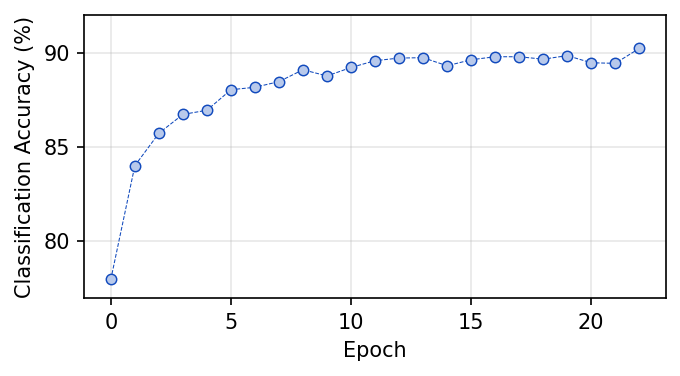

In [40]:
plt.figure(figsize=(5, 2.5), dpi=150)
plot_dots_v2(epoch, accu*100, marker_pat, color_pat, label="Physics-Aware Training")
plt.grid(alpha=0.3)
plt.ylim(top=92, bottom=77)
plt.yticks([80, 85, 90])

plt.xlabel("Epoch")
plt.ylabel("Classification Accuracy (%)")
